In [91]:
import os
import random
import shutil
import os
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



# GPU memory growth configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [92]:
def split_data1(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      shutil.copyfile(item_source, os.path.join(target, item))
      i += 1

    
    if i == training_number:
      target = TESTING

In [145]:
source_path = r"/Users/sulthanfatahillah/Downloads/Datasets"

source_ai_dir = r"/Users/sulthanfatahillah/Downloads/Datasets/AI"
source_human_dir = r"/Users/sulthanfatahillah/Downloads/Datasets/Non-AI"

training_dir = r"/Users/sulthanfatahillah/Downloads/split-data/Training"
validation_dir = r"/Users/sulthanfatahillah/Downloads/split-data/Validation"

train_ai_dir = os.path.join(training_dir, 'AI')
train_human_dir = os.path.join(training_dir, 'Non-Ai')

val_human_dir = os.path.join(validation_dir, 'Non-AI')
val_ai_dir = os.path.join(validation_dir, 'AI')

if len(os.listdir(train_human_dir)) > 0:
  for file in os.scandir(train_human_dir):
    os.remove(file.path)
if len(os.listdir(train_ai_dir)) > 0:
  for file in os.scandir(train_ai_dir):
    os.remove(file.path)
if len(os.listdir(val_human_dir)) > 0:
  for file in os.scandir(val_human_dir):
    os.remove(file.path)
if len(os.listdir(val_ai_dir)) > 0:
  for file in os.scandir(val_ai_dir):
    os.remove(file.path)
    
split_size = .9


!find /Users/sulthanfatahillah/Downloads/Datasets -type f ! -name "*.jpg" -exec rm {} +

split_data1(source_human_dir, train_human_dir, val_human_dir, split_size)
split_data1(source_ai_dir, train_ai_dir, val_ai_dir, split_size)

print(f"There are {len(os.listdir(train_human_dir))} images of human art for training")
print(f"There are {len(os.listdir(train_ai_dir))} images of AI generated for training")
print(f"There are {len(os.listdir(val_human_dir))} images of human art for validation")
print(f"There are {len(os.listdir(val_ai_dir))} images of AI generated for validation")

There are 21713 images of human art for training
There are 20250 images of AI generated for training
There are 2413 images of human art for validation
There are 2251 images of AI generated for validation


In [152]:

def create_model():

  model = tf.keras.models.Sequential([
      
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

  return model

In [162]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('accuracy') > 0.94):

     
      print("\nAccuracy lebih dari 94, stop training!")
      self.model.stop_training = True


callbacks = myCallback()

In [165]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        training_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 41963 images belonging to 2 classes.
Found 4664 images belonging to 2 classes.


In [166]:
EPOCHS = 20


model = create_model()


history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=2,
      callbacks=[callbacks])

Epoch 1/20
1312/1312 - 407s - loss: 1.0854 - accuracy: 0.7842 - val_loss: 0.3740 - val_accuracy: 0.8066 - 407s/epoch - 310ms/step
Epoch 2/20
1312/1312 - 471s - loss: 0.3359 - accuracy: 0.8352 - val_loss: 0.3410 - val_accuracy: 0.8321 - 471s/epoch - 359ms/step
Epoch 3/20
1312/1312 - 476s - loss: 0.2763 - accuracy: 0.8740 - val_loss: 0.3552 - val_accuracy: 0.8373 - 476s/epoch - 363ms/step
Epoch 4/20
1312/1312 - 476s - loss: 0.2336 - accuracy: 0.8991 - val_loss: 0.3476 - val_accuracy: 0.8563 - 476s/epoch - 362ms/step
Epoch 5/20
1312/1312 - 471s - loss: 0.2126 - accuracy: 0.9101 - val_loss: 0.3350 - val_accuracy: 0.8611 - 471s/epoch - 359ms/step
Epoch 6/20
1312/1312 - 469s - loss: 0.1868 - accuracy: 0.9199 - val_loss: 0.3173 - val_accuracy: 0.8754 - 469s/epoch - 357ms/step
Epoch 7/20
1312/1312 - 466s - loss: 0.1762 - accuracy: 0.9256 - val_loss: 0.3324 - val_accuracy: 0.8690 - 466s/epoch - 355ms/step
Epoch 8/20
1312/1312 - 464s - loss: 0.1920 - accuracy: 0.9204 - val_loss: 0.3501 - val_acc

In [169]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

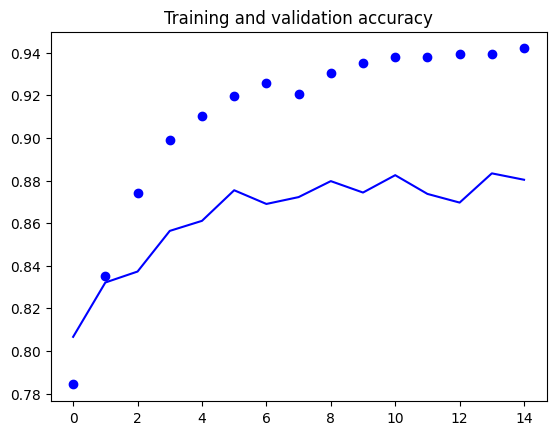

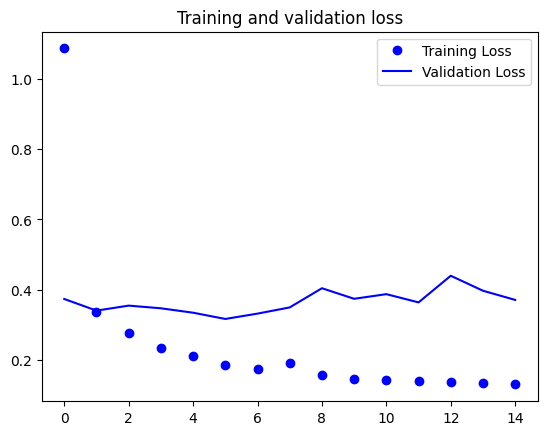

In [170]:
# Plot training results
plot_loss_acc(history)

In [171]:
import pickle

with open('latestmodel.pkl', 'wb') as f:
    pickle.dump(model,f)